In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Cargar el dataset
try:
    df = pd.read_csv('data_clean.csv')
except FileNotFoundError:
    print("Error: No encontrado")
    exit()

df.info()

print("\n--- Estadísticas Descriptivas de las primeras 5 columnas ---")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 97 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   Unnamed: 0                                              6819 non-null   int64  
 1   BANKRUPT                                                6819 non-null   int64  
 2   ROA_C_BEFORE_INTEREST_AND_DEPRECIATION_BEFORE_INTEREST  6819 non-null   float64
 3   ROA_A_BEFORE_INTEREST_AND__AFTER_TAX                    6819 non-null   float64
 4   ROA_B_BEFORE_INTEREST_AND_DEPRECIATION_AFTER_TAX        6819 non-null   float64
 5   OPERATING_GROSS_MARGIN                                  6819 non-null   float64
 6   REALIZED_SALES_GROSS_MARGIN                             6819 non-null   float64
 7   OPERATING_PROFIT_RATE                                   6819 non-null   float64
 8   PRETAX_NET_INTEREST_RATE              

In [2]:
abs(df.corr()['BANKRUPT']).sort_values(ascending=False).head(20)

BANKRUPT                                                  1.000000
NET_INCOME_TO_TOTAL_ASSETS                                0.315457
ROA_A_BEFORE_INTEREST_AND__AFTER_TAX                      0.282941
ROA_B_BEFORE_INTEREST_AND_DEPRECIATION_AFTER_TAX          0.273051
ROA_C_BEFORE_INTEREST_AND_DEPRECIATION_BEFORE_INTEREST    0.260807
NET_WORTHASSETS                                           0.250161
DEBT_RATIO                                                0.250161
PERSISTENT_EPS_IN_THE_LAST_FOUR_SEASONS                   0.219560
RETAINED_EARNINGS_TO_TOTAL_ASSETS                         0.217779
NET_PROFIT_BEFORE_TAXPAIDIN_CAPITAL                       0.207857
PER_SHARE_NET_PROFIT_BEFORE_TAX__YUAN                     0.201395
CURRENT_LIABILITY_TO_ASSETS                               0.194494
WORKING_CAPITAL_TO_TOTAL_ASSETS                           0.193083
NET_INCOME_TO_STOCKHOLDERS_EQUITY                         0.180987
BORROWING_DEPENDENCY                                      0.17

In [3]:
thres=0.2
fil_cols=[col for col in df.columns if abs(df.corr()['BANKRUPT'][col])>thres]
df_filt=df[fil_cols]

In [17]:
print(len(df_filt.columns))

11


In [4]:
# 1. Dividir el dataset en conjuntos de entrenamiento y prueba (antes de aplicar SMOTE)
X=df_filt.drop('BANKRUPT',axis=1)
y=df_filt['BANKRUPT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, stratify=y)
#X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42,)

print(f"\n--- Distribución de clases en el conjunto de entrenamiento antes de SMOTE ---")
print(y_train.value_counts())

# 2. Aplicar SMOTE al conjunto de entrenamiento
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"\n--- Distribución de clases en el conjunto de entrenamiento después de SMOTE ---")
print(y_train_resampled.value_counts())


--- Distribución de clases en el conjunto de entrenamiento antes de SMOTE ---
BANKRUPT
0    4619
1     154
Name: count, dtype: int64

--- Distribución de clases en el conjunto de entrenamiento después de SMOTE ---
BANKRUPT
0    4619
1    4619
Name: count, dtype: int64


/Users/rpitti/Downloads/OneDrive_5_6-9-2025/.venv/lib/python3.9/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Inicializar y entrenar el modelo de Regresión Logística
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Entrenamos con los datos balanceados
log_reg.fit(X_train_resampled, y_train_resampled)

# Predicciones en el conjunto de prueba (NO balanceado)
y_pred_log_reg = log_reg.predict(X_test)
y_prob_log_reg = log_reg.predict_proba(X_test)[:, 1] # Probabilidades para la clase 1 (Bancarrota)

# Evaluación
print("--- Evaluación: Regresión Logística ---")
print(classification_report(y_test, y_pred_log_reg))
print("Área bajo la curva ROC (AUC):", roc_auc_score(y_test, y_prob_log_reg))

--- Evaluación: Regresión Logística ---
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      1980
           1       0.16      0.85      0.26        66

    accuracy                           0.85      2046
   macro avg       0.58      0.85      0.59      2046
weighted avg       0.97      0.85      0.89      2046

Área bajo la curva ROC (AUC): 0.9200566268748087


In [6]:
from sklearn.ensemble import RandomForestClassifier

# Inicializar y entrenar el modelo Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenamos con los datos balanceados
rf_clf.fit(X_train_resampled, y_train_resampled)

# Predicciones en el conjunto de prueba (NO balanceado)
y_pred_rf = rf_clf.predict(X_test)
y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]

# Evaluación
print("\n--- Evaluación: Random Forest ---")
print(classification_report(y_test, y_pred_rf))
print("Área bajo la curva ROC (AUC):", roc_auc_score(y_test, y_prob_rf))


--- Evaluación: Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1980
           1       0.26      0.58      0.35        66

    accuracy                           0.93      2046
   macro avg       0.62      0.76      0.66      2046
weighted avg       0.96      0.93      0.94      2046

Área bajo la curva ROC (AUC): 0.8785583103764922


In [7]:
import xgboost as xgb

# Inicializar y entrenar el modelo XGBoost
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, random_state=42)

# Entrenamos con los datos balanceados
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predicciones en el conjunto de prueba
y_pred_xgb = xgb_clf.predict(X_test)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]

# Evaluación
print("\n--- Evaluación: XGBoost ---")
print(classification_report(y_test, y_pred_xgb))
print("Área bajo la curva ROC (AUC):", roc_auc_score(y_test, y_prob_xgb))


--- Evaluación: XGBoost ---
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1980
           1       0.24      0.61      0.34        66

    accuracy                           0.93      2046
   macro avg       0.61      0.77      0.65      2046
weighted avg       0.96      0.93      0.94      2046

Área bajo la curva ROC (AUC): 0.8758991429445975


/Users/rpitti/Downloads/OneDrive_5_6-9-2025/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [07:44:53] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [8]:
from lightgbm import LGBMClassifier
# Separar X y y
X = df.drop('BANKRUPT', axis=1)
y = df['BANKRUPT']

# Escalar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

# Instanciar modelo
clf = LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    is_unbalance=True,
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=200
)

# Entrenar con early stopping
clf.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc'
)

# Predicciones
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

# Evaluar
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred_prob))
gini = 2 * roc_auc_score(y_test, y_pred_prob) - 1

print(f"Gini: {gini:.4f}")

[LightGBM] [Info] Number of positive: 176, number of negative: 5279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23968
[LightGBM] [Info] Number of data points in the train set: 5455, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032264 -> initscore=-3.401008
[LightGBM] [Info] Start training from score -3.401008
[[1305   15]
 [  19   25]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1320
           1       0.62      0.57      0.60        44

    accuracy                           0.98      1364
   macro avg       0.81      0.78      0.79      1364
weighted avg       0.97      0.98      0.97      1364

ROC AUC: 0.9537017906336088
Gini: 0.9074


/Users/rpitti/Downloads/OneDrive_5_6-9-2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/rpitti/Downloads/OneDrive_5_6-9-2025/.venv/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


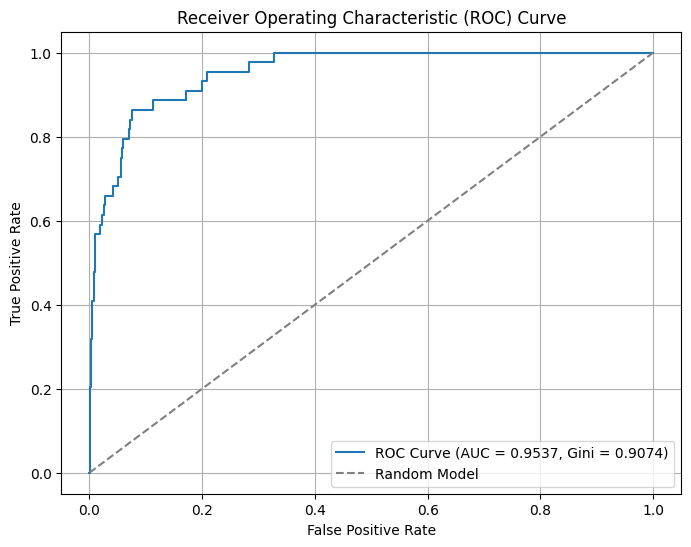

In [9]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcular AUC
auc = roc_auc_score(y_test, y_pred_prob)
gini = 2 * auc - 1

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.4f}, Gini = {gini:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Model')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

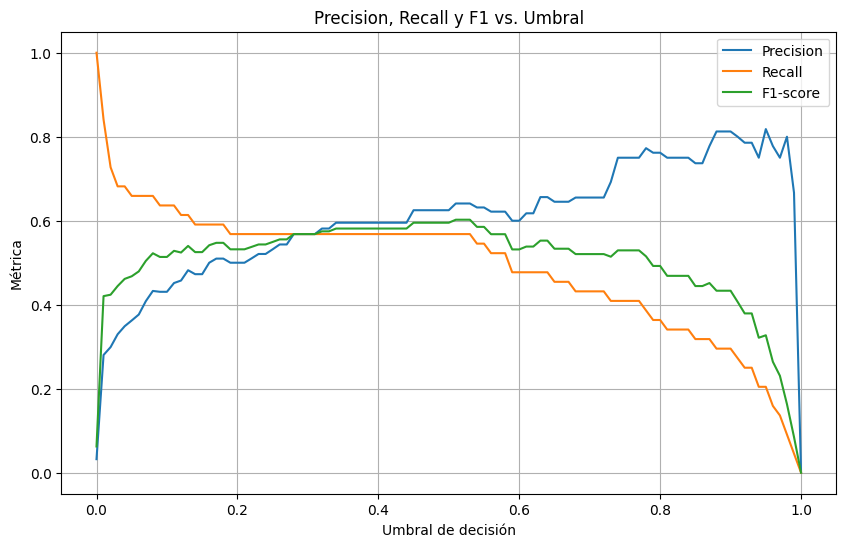

Mejor umbral según F1: 0.51 (F1=0.6024)


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Rango de umbrales
thresholds = np.arange(0.0, 1.01, 0.01)

precision_list = []
recall_list = []
f1_list = []

for t in thresholds:
    y_pred_t = (y_pred_prob >= t).astype(int)
    precision_list.append(precision_score(y_test, y_pred_t, zero_division=0))
    recall_list.append(recall_score(y_test, y_pred_t))
    f1_list.append(f1_score(y_test, y_pred_t))

# Graficar
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1-score')
plt.xlabel('Umbral de decisión')
plt.ylabel('Métrica')
plt.title('Precision, Recall y F1 vs. Umbral')
plt.legend()
plt.grid(True)
plt.show()

# Opcional: Umbral con máximo F1
best_idx = np.argmax(f1_list)
best_threshold = thresholds[best_idx]
print(f"Mejor umbral según F1: {best_threshold:.2f} (F1={f1_list[best_idx]:.4f})")

In [18]:
# Predicción con umbral óptimo
y_pred_opt = (y_pred_prob >= 0.51).astype(int)

# Nuevo reporte
print("\n--- Evaluación: LightGBM con HyperParameter Tuning y Feature Reduction ---")
print(classification_report(y_test, y_pred_opt))

# AUC se mantiene igual porque no depende del umbral
auc = roc_auc_score(y_test, y_pred_prob)
print(f"AUC: {auc:.4f}")


--- Evaluación: LightGBM con HyperParameter Tuning y Feature Reduction ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1320
           1       0.64      0.57      0.60        44

    accuracy                           0.98      1364
   macro avg       0.81      0.78      0.79      1364
weighted avg       0.97      0.98      0.98      1364

AUC: 0.9537


In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_opt)
print("Matriz de confusión con umbral 0.51:")
print(cm)

Matriz de confusión con umbral 0.51:
[[1306   14]
 [  19   25]]
